In [19]:
import os
import sys
directory_path = os.path.abspath(os.path.join('..'))
if directory_path not in sys.path:
    sys.path.append(directory_path)
os.chdir(directory_path)
# Only for final delivery
import warnings
warnings.filterwarnings('ignore')
# libraries for visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme(style="white")
# Libraries models
import pandas as pd
import numpy as np
from collections import Counter
from time import time
# Set some Pandas options
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 25)
import matplotlib.pyplot as plt
get_ipython().magic(u'matplotlib inline') 
get_ipython().magic(u"config InlineBackend.figure_format='retina'")
import seaborn as sns
# Library's to apply balance technic's
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
# Import the necessary module's
from scipy.stats import chi2
from sklearn.preprocessing import binarize
from sklearn.model_selection import train_test_split,GridSearchCV,cross_validate,cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve,classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,IsolationForest
from sklearn.naive_bayes import ComplementNB
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
# library to save the models
import joblib
# library to save the models
import joblib

In [2]:
def get_na(df):
    qsna=df.shape[0]-df.isnull().sum(axis=0)
    qna=df.isnull().sum(axis=0)
    ppna=round(100*(df.isnull().sum(axis=0)/df.shape[0]),2)
    aux= {'datos sin NAs en q': qsna, 'Na en q': qna ,'Na en %': ppna}
    na=pd.DataFrame(data=aux)
    return na.sort_values(by='Na en %',ascending=False)

def plot_pie(y):
    target_stats = Counter(y)
    labels = list(target_stats.keys())
    sizes = list(target_stats.values())
    explode = tuple([0.1] * len(target_stats))

    fig, ax = plt.subplots()
    ax.pie(sizes, explode=explode, labels=labels, shadow=True,
           autopct='%1.1f%%')
    ax.axis('equal')

In [3]:
path = os.getcwd() + '/data/interim/model_data_train_ohe.csv' 
X_train = pd.read_csv(path, sep=',')
path = os.getcwd() + '/data/interim/model_data_test_ohe.csv' 
X_test = pd.read_csv(path, sep=',')
path = os.getcwd() + '/data/interim/y_train_ohe.csv' 
y_train = pd.read_csv(path, sep=',')
path = os.getcwd() + '/data/interim/y_test_ohe.csv' 
y_test = pd.read_csv(path, sep=',')

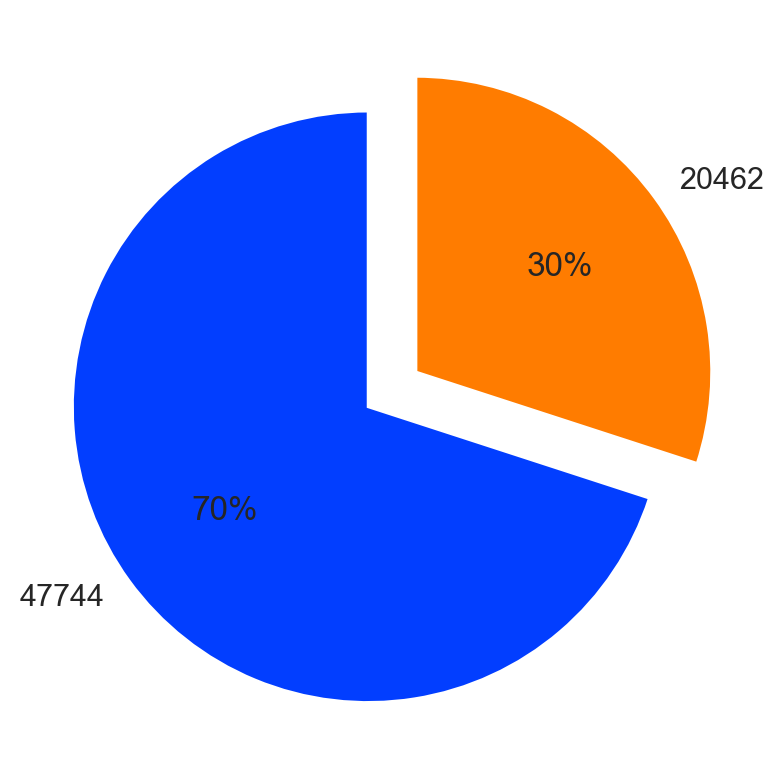

In [4]:
#define data
data = [X_train.shape[0],X_test.shape[0] ]
labels = [data[0], data[1]]
#define Seaborn color palette to use
colors = sns.color_palette('bright')[0:2]
#create pie chart
plt.pie(data, labels = labels, colors = colors,startangle=90, 
        autopct='%1.f%%',explode=(0.1,0.1))
plt.show()

Información del dataset:
 las clases del target son: Counter({0: 38914, 1: 8830})


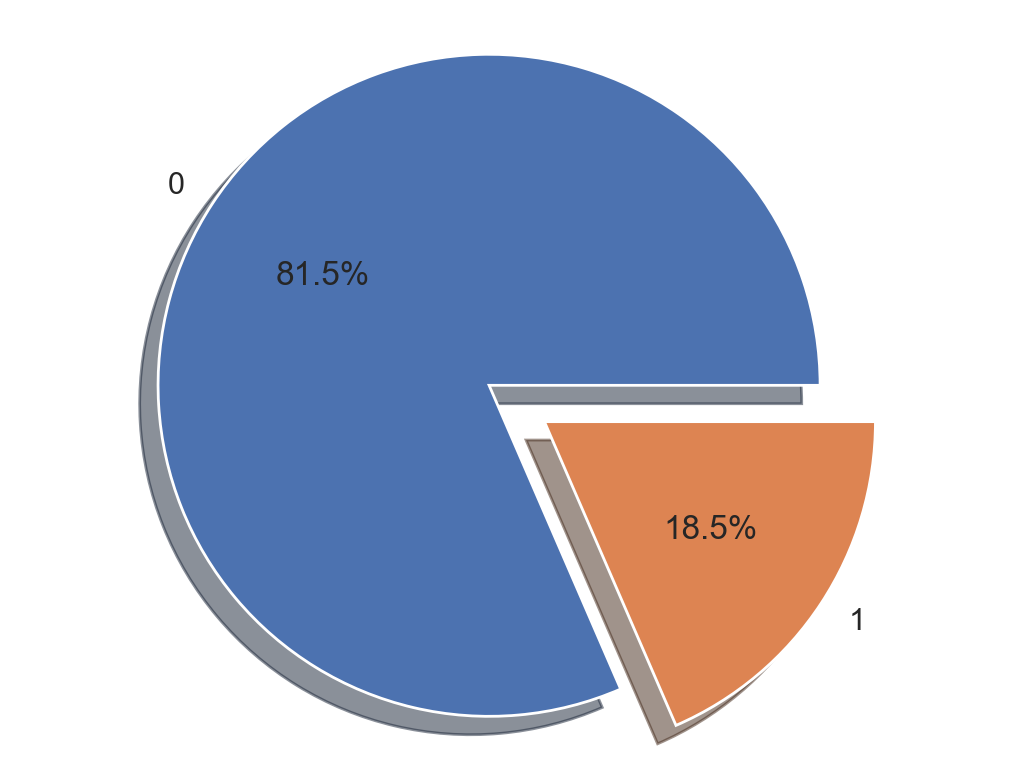

In [5]:
print('Información del dataset:'
      '\n las clases del target son: {}'.format(Counter(y_train.atraso_15)))
plot_pie(y_train.atraso_15)

In [6]:
clf = ComplementNB(alpha=0.1,class_prior = [0.815,0.185] )
scores = cross_val_score(clf, X_train, y_train, cv=10, scoring='precision')
print(scores.mean())
clf.fit(X_train, y_train)
y_pred_probs = clf.predict_proba(X_test)[:,1]
y_pred = y_pred_probs>=0.5
cm = pd.crosstab(y_test.atraso_15, y_pred, rownames=['Actual class'], colnames=['Predicted class'],margins=True)
report = classification_report(y_test.atraso_15, y_pred)
print(roc_auc_score(y_test.atraso_15, y_pred_probs))
print(report)
cm

0.2725040678990672
0.6749018120109616
              precision    recall  f1-score   support

           0       0.88      0.65      0.74     16678
           1       0.28      0.60      0.38      3784

    accuracy                           0.64     20462
   macro avg       0.58      0.62      0.56     20462
weighted avg       0.77      0.64      0.68     20462



Predicted class,False,True,All
Actual class,,,
0,10796,5882,16678
1,1524,2260,3784
All,12320,8142,20462


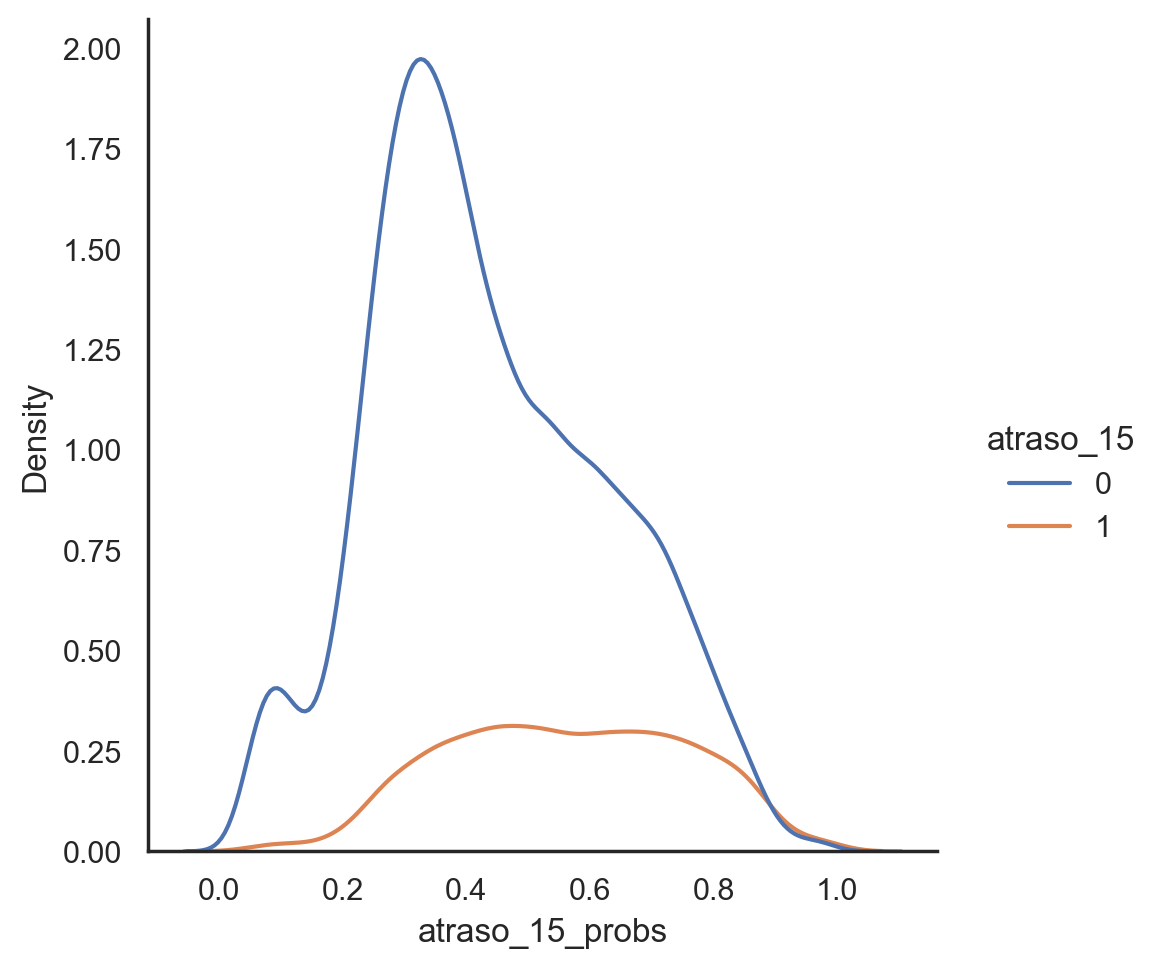

In [7]:
y_test['atraso_15_probs'] = y_pred_probs
sns.displot(data=y_test, x="atraso_15_probs", hue="atraso_15",kind="kde");

In [8]:
clf = DecisionTreeClassifier(random_state=0, max_features='sqrt',criterion='gini',
                             min_samples_split=0.001)
scores = cross_val_score(clf, X_train, y_train, cv=10, scoring='precision')
print(scores.mean())
clf.fit(X_train, y_train)
y_pred_probs = clf.predict_proba(X_test)[:,1]
y_pred = y_pred_probs>=0.5
cm = pd.crosstab(y_test.atraso_15, y_pred, rownames=['Actual class'], colnames=['Predicted class'],margins=True)
report = classification_report(y_test.atraso_15, y_pred)
print(roc_auc_score(y_test.atraso_15, y_pred_probs))
print(report)
cm

0.4430729272612754
0.6684449130616551
              precision    recall  f1-score   support

           0       0.84      0.94      0.89     16678
           1       0.42      0.18      0.25      3784

    accuracy                           0.80     20462
   macro avg       0.63      0.56      0.57     20462
weighted avg       0.76      0.80      0.77     20462



Predicted class,False,True,All
Actual class,,,
0,15704,974,16678
1,3093,691,3784
All,18797,1665,20462


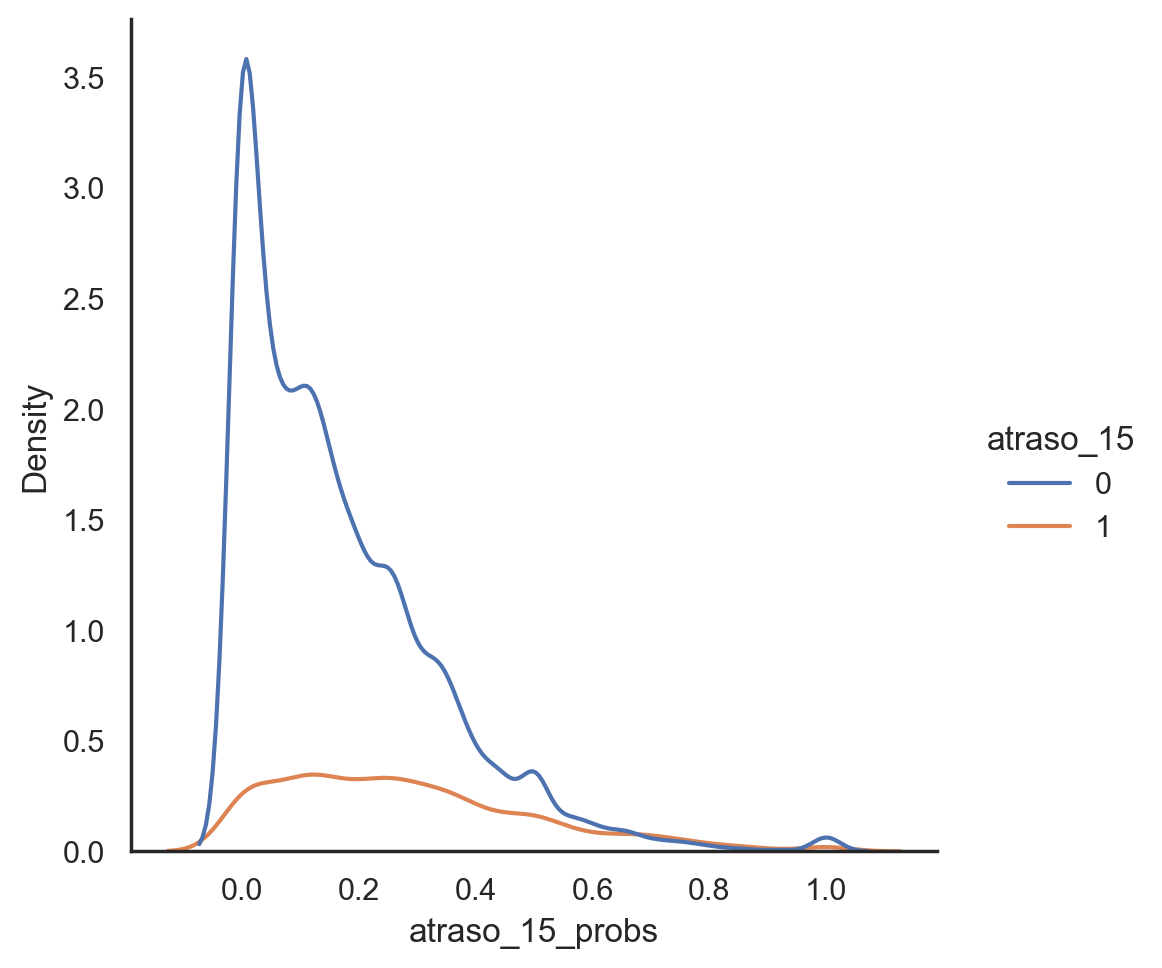

In [9]:
y_test['atraso_15_probs'] = y_pred_probs
sns.displot(data=y_test, x="atraso_15_probs", hue="atraso_15",kind="kde");

In [10]:
clf = LogisticRegression()
scores = cross_val_score(clf, X_train, y_train, cv=10, scoring='precision')
print(scores.mean())
clf.fit(X_train, y_train)
y_pred_probs = clf.predict_proba(X_test)[:,1]
y_pred = y_pred_probs>=0.5
cm = pd.crosstab(y_test.atraso_15, y_pred, rownames=['Actual class'], colnames=['Predicted class'],margins=True)
report = classification_report(y_test.atraso_15, y_pred)
print(roc_auc_score(y_test.atraso_15, y_pred_probs))
print(report)
cm

0.5249594546684471
0.6889052864770772
              precision    recall  f1-score   support

           0       0.82      0.99      0.90     16678
           1       0.56      0.05      0.09      3784

    accuracy                           0.82     20462
   macro avg       0.69      0.52      0.49     20462
weighted avg       0.77      0.82      0.75     20462



Predicted class,False,True,All
Actual class,,,
0,16540,138,16678
1,3609,175,3784
All,20149,313,20462


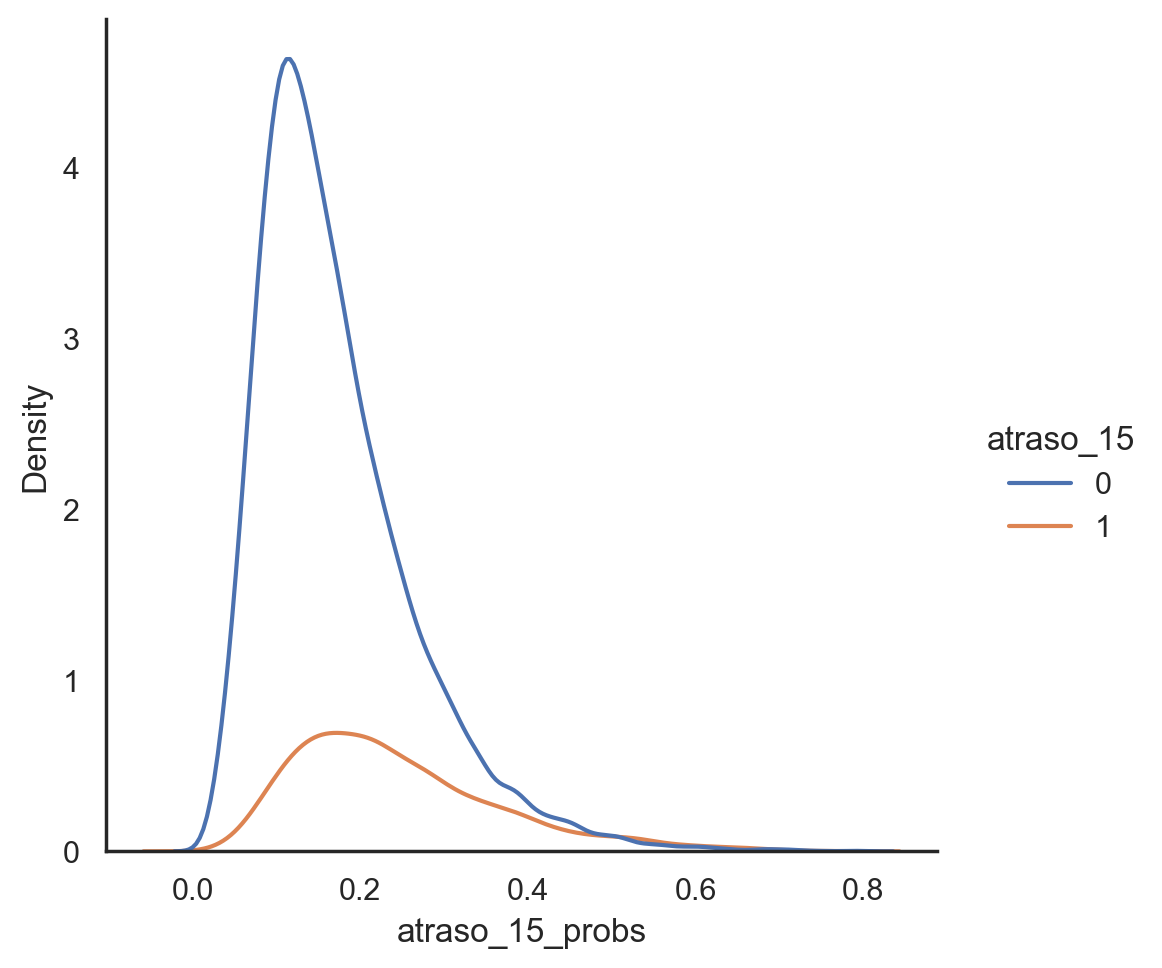

In [11]:
y_test['atraso_15_probs'] = y_pred_probs
sns.displot(data=y_test, x="atraso_15_probs", hue="atraso_15",kind="kde");

In [12]:
clf = RandomForestClassifier(n_estimators=500,random_state=0,warm_start=True,criterion='gini',
                             bootstrap=True,max_features='sqrt')
scores = cross_val_score(clf, X_train, y_train, cv=10, scoring='precision')
print(scores.mean())
clf.fit(X_train, y_train)
y_pred_probs = clf.predict_proba(X_test)[:,1]
y_pred = y_pred_probs>=0.5
cm = pd.crosstab(y_test.atraso_15, y_pred, rownames=['Actual class'], colnames=['Predicted class'],margins=True)
report = classification_report(y_test.atraso_15, y_pred)
print(roc_auc_score(y_test.atraso_15, y_pred_probs))
print(report)
cm

0.42112699196894166
0.694330233876482
              precision    recall  f1-score   support

           0       0.84      0.93      0.88     16678
           1       0.41      0.21      0.27      3784

    accuracy                           0.80     20462
   macro avg       0.62      0.57      0.58     20462
weighted avg       0.76      0.80      0.77     20462



Predicted class,False,True,All
Actual class,,,
0,15551,1127,16678
1,3008,776,3784
All,18559,1903,20462


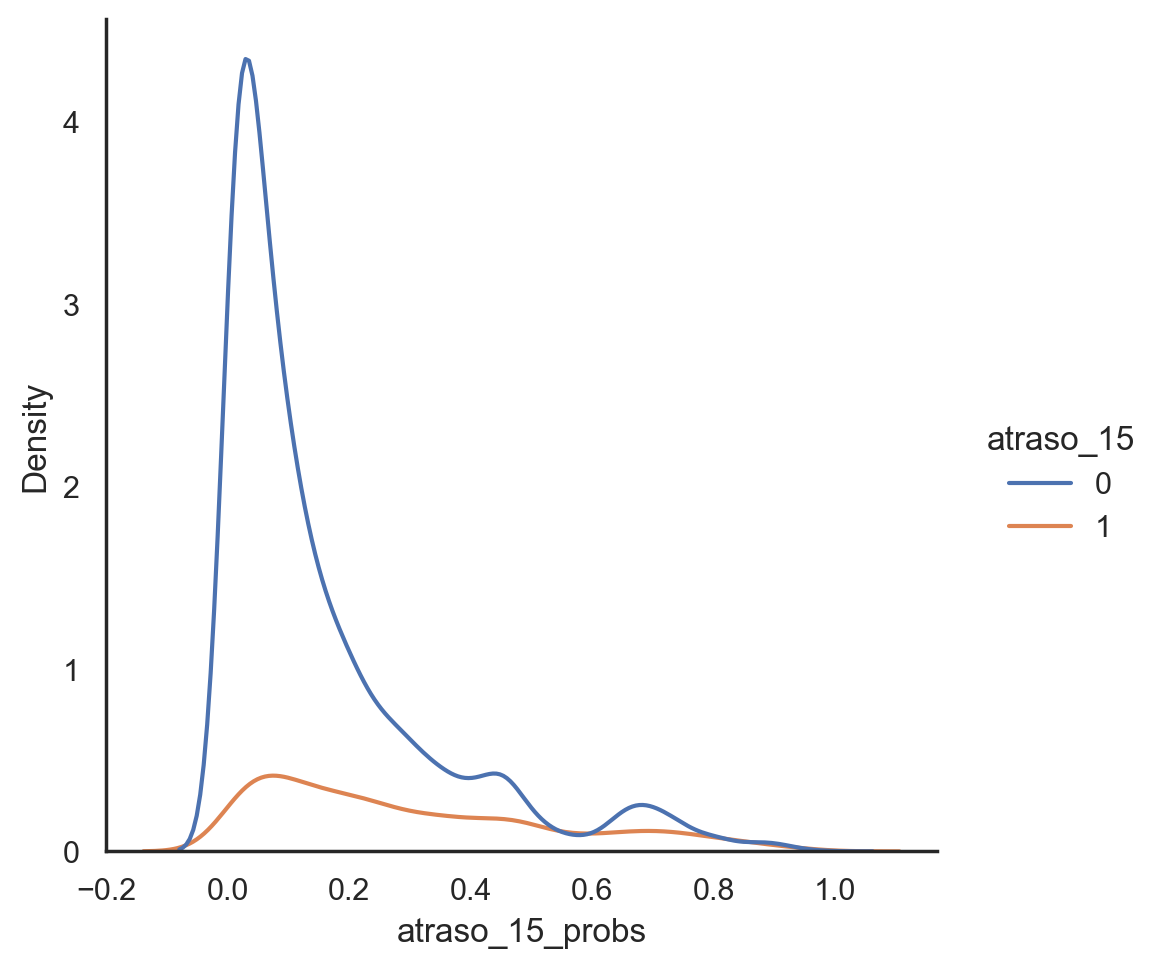

In [13]:
y_test['atraso_15_probs'] = y_pred_probs
sns.displot(data=y_test, x="atraso_15_probs", hue="atraso_15",kind="kde");

In [14]:
clf = XGBClassifier(random_state=0,verbosity = 0)
scores = cross_val_score(clf, X_train, y_train, cv=10, scoring='precision')
print(scores.mean())
clf.fit(X_train, y_train)
y_pred_probs = clf.predict_proba(X_test)[:,1]
y_pred = y_pred_probs>=0.5
cm = pd.crosstab(y_test.atraso_15, y_pred, rownames=['Actual class'], colnames=['Predicted class'],margins=True)
report = classification_report(y_test.atraso_15, y_pred)
print(roc_auc_score(y_test.atraso_15, y_pred_probs))
print(report)
cm

0.602832168976933
0.7311003015835067
              precision    recall  f1-score   support

           0       0.83      0.98      0.90     16678
           1       0.59      0.14      0.22      3784

    accuracy                           0.82     20462
   macro avg       0.71      0.56      0.56     20462
weighted avg       0.79      0.82      0.77     20462



Predicted class,False,True,All
Actual class,,,
0,16324,354,16678
1,3266,518,3784
All,19590,872,20462


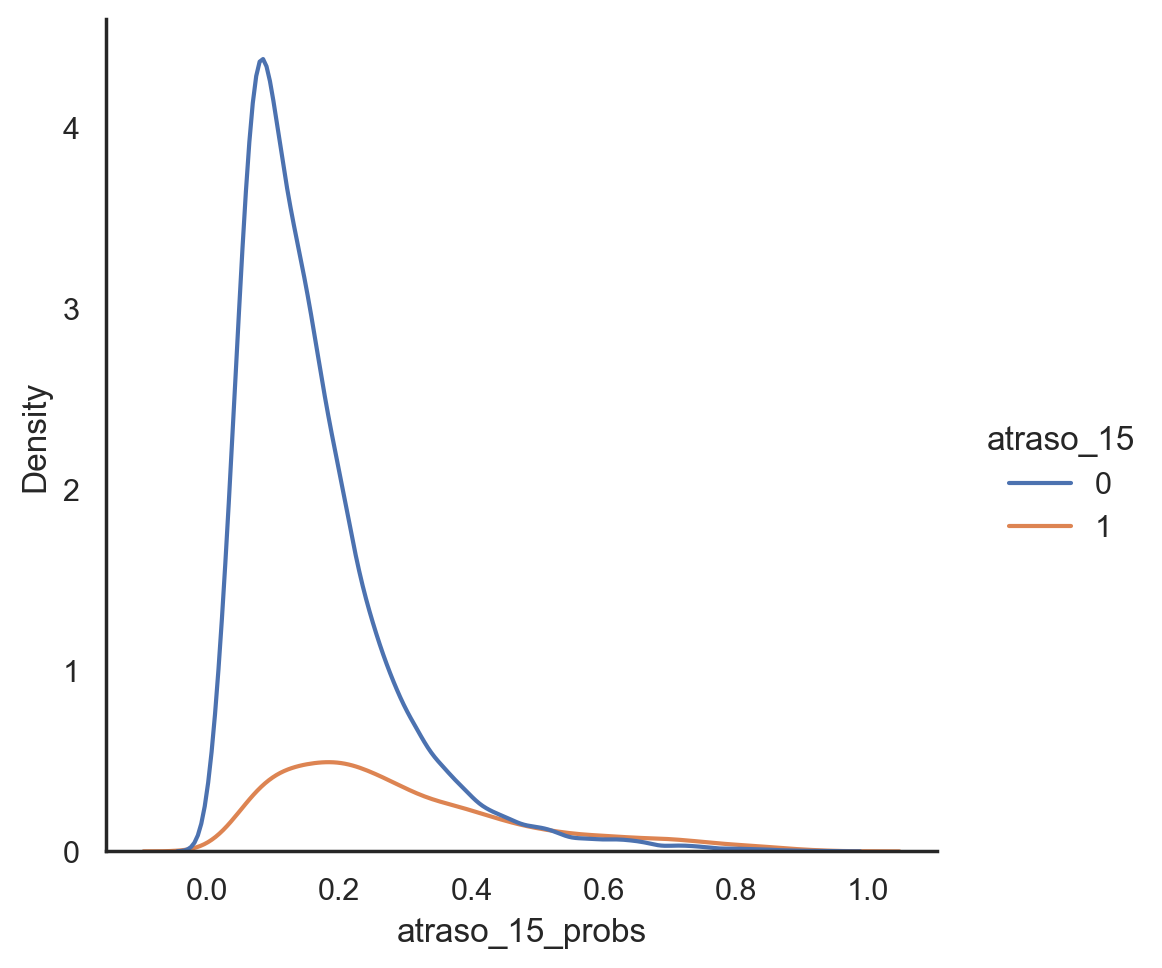

In [15]:
y_test['atraso_15_probs'] = y_pred_probs
sns.displot(data=y_test, x="atraso_15_probs", hue="atraso_15",kind="kde");

In [22]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(random_state=1, max_iter=300).fit(X_train, y_train)
scores = cross_val_score(clf, X_train, y_train, cv=10, scoring='precision')
print(scores.mean())
clf.fit(X_train, y_train)
y_pred_probs = clf.predict_proba(X_test)[:,1]
y_pred = y_pred_probs>=0.5
cm = pd.crosstab(y_test.atraso_15, y_pred, rownames=['Actual class'], colnames=['Predicted class'],margins=True)
report = classification_report(y_test.atraso_15, y_pred)
print(roc_auc_score(y_test.atraso_15, y_pred_probs))
print(report)
cm

0.38186644459008356
0.6765137866927022
              precision    recall  f1-score   support

           0       0.85      0.90      0.87     16678
           1       0.39      0.29      0.34      3784

    accuracy                           0.78     20462
   macro avg       0.62      0.60      0.60     20462
weighted avg       0.76      0.78      0.77     20462



Predicted class,False,True,All
Actual class,,,
0,14942,1736,16678
1,2670,1114,3784
All,17612,2850,20462


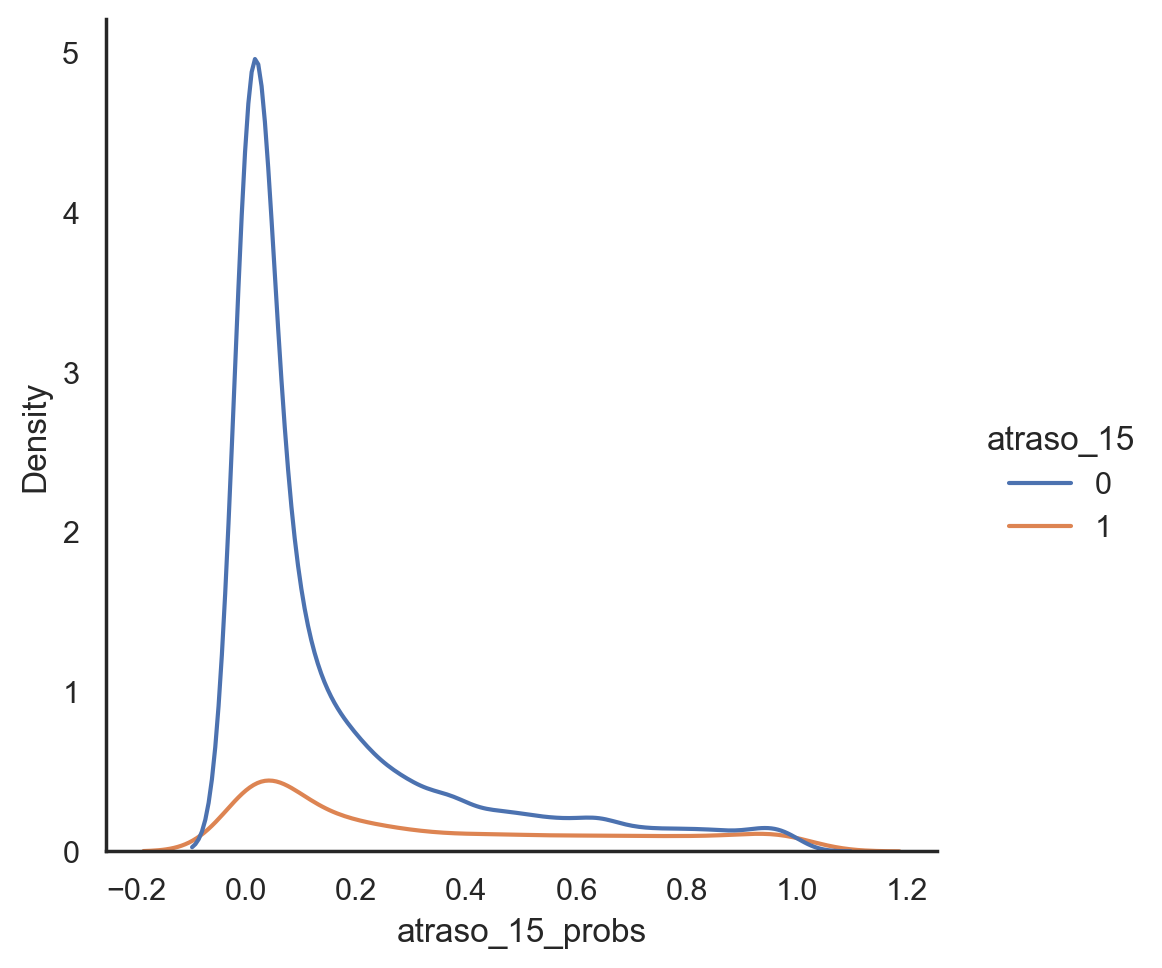

In [23]:
y_test['atraso_15_probs'] = y_pred_probs
sns.displot(data=y_test, x="atraso_15_probs", hue="atraso_15",kind="kde");